# Цель проекта

Для построения модели зависимости успеваемости учащихся по математике от условий их жизни из имеющихся данных выбрать факторы, которые должны стать параметрами будущей модели.

# Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from itertools import combinations
from scipy.stats import ttest_ind
%matplotlib inline

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

stud_math = pd.read_csv('stud_math.csv')

# 1. Первичная обработка данных

In [2]:
stud_math.shape

(395, 30)

In [3]:
stud_math.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


In [4]:
stud_math.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime, granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score'],
      dtype='object')

In [5]:
# Удалим лишний столбец "studytime, granular" (не включен в аннотацию) и столбец "school", так как он не нужен при анализе
stud_math.drop(columns=['studytime, granular', 'school'], axis='column', inplace=True)

In [6]:
stud_math.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sex         395 non-null    object 
 1   age         395 non-null    int64  
 2   address     378 non-null    object 
 3   famsize     368 non-null    object 
 4   Pstatus     350 non-null    object 
 5   Medu        392 non-null    float64
 6   Fedu        371 non-null    float64
 7   Mjob        376 non-null    object 
 8   Fjob        359 non-null    object 
 9   reason      378 non-null    object 
 10  guardian    364 non-null    object 
 11  traveltime  367 non-null    float64
 12  studytime   388 non-null    float64
 13  failures    373 non-null    float64
 14  schoolsup   386 non-null    object 
 15  famsup      356 non-null    object 
 16  paid        355 non-null    object 
 17  activities  381 non-null    object 
 18  nursery     379 non-null    object 
 19  higher      375 non-null    o

In [7]:
# Удаляем записи, у которых не определен столбец "score", для модели такие записи будут бесполезны
stud_math.drop(stud_math[pd.isnull(stud_math['score'])].index, axis='index', inplace=True)

In [8]:
stud_math.shape

(389, 28)

Наш набор содержит три вида данных:
- номинальные ("sex", "address", "famsize", "Pstatus ", "Mjob", "Fjob", "reason", "guardian", "schoolsup", "famsup",
               "paid", "activities", "nursery", "higher", "internet", "romantic")
- порядковые ("Medu", "Fedu", "traveltime", "studytime", "famrel", "freetime", "goout", "health")
- непрерывные ("age", "failures", "absences", "score")

In [9]:
# Судя по условию, в столбце "failures" данные можно использовать только при 1<=n<=3, так как n=0 и n=4+ данные попадут
# в одну группу n=0, поэтому присвоим всем ячейками с n=0 значение Null, чтобы исключить их из анализа
stud_math['failures'].apply(lambda x: None if x == 0 else x)

0      NaN
1      NaN
2      3.0
3      NaN
4      NaN
      ... 
390    2.0
391    NaN
392    3.0
393    NaN
394    NaN
Name: failures, Length: 389, dtype: float64

Проанализируем каждую переменную отдельно

In [10]:
# Функция дает краткое описание каждого номинального столбца
def describe_object_columns(column):
    if stud_math[column].dtype == 'object':
        # Преобразуем пустые ячейки в Null
        stud_math[column].apply(lambda x: None if (x == 'NaN' or x == '') else x)
        print(f'Столбец {column}')
        print()
        # Количество уникальных значений аналитик
        print(
            f'Всего уникальных значений признака: {stud_math[column].unique().size}')
        # Количество значений каждой аналитики
        display(stud_math[column].value_counts())
        # Количество значений Null
        print(
            f'Пустых значений: {stud_math.loc[pd.isnull(stud_math[column])][column].size}')
        # Графическое отображение количества каждой аналитики
        stud_math[column].value_counts().plot(kind='bar')
        plt.show()

        print()
        print()

Столбец sex

Всего уникальных значений признака: 2


F    204
M    185
Name: sex, dtype: int64

Пустых значений: 0


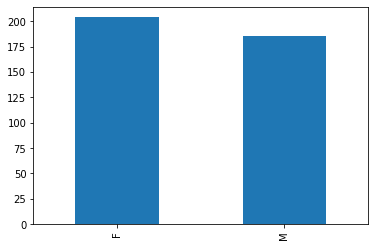



Столбец address

Всего уникальных значений признака: 3


U    291
R     83
Name: address, dtype: int64

Пустых значений: 15


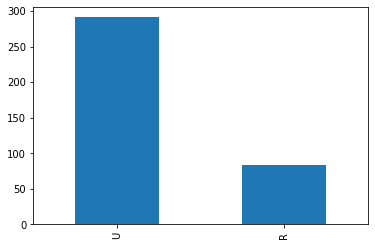



Столбец famsize

Всего уникальных значений признака: 3


GT3    255
LE3    107
Name: famsize, dtype: int64

Пустых значений: 27


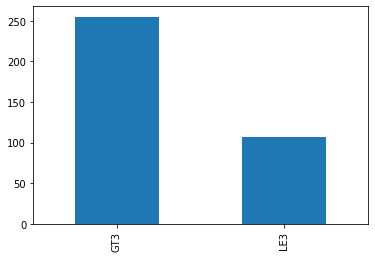



Столбец Pstatus

Всего уникальных значений признака: 3


T    308
A     36
Name: Pstatus, dtype: int64

Пустых значений: 45


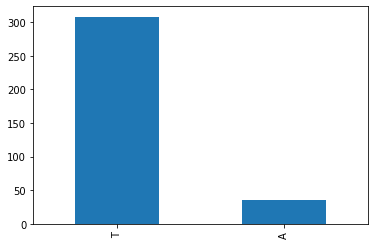



Столбец Mjob

Всего уникальных значений признака: 6


other       127
services     98
at_home      58
teacher      55
health       32
Name: Mjob, dtype: int64

Пустых значений: 19


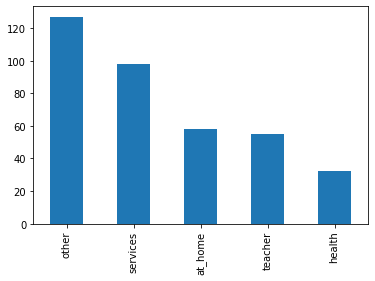



Столбец Fjob

Всего уникальных значений признака: 6


other       194
services     99
teacher      29
at_home      16
health       15
Name: Fjob, dtype: int64

Пустых значений: 36


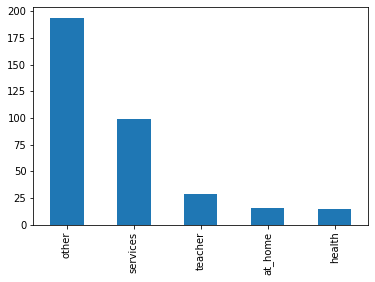



Столбец reason

Всего уникальных значений признака: 5


course        135
reputation    102
home          101
other          34
Name: reason, dtype: int64

Пустых значений: 17


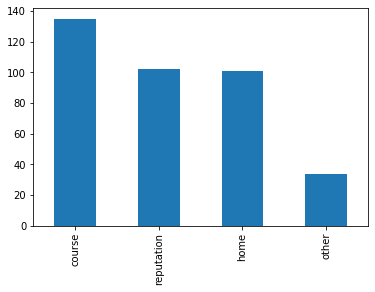



Столбец guardian

Всего уникальных значений признака: 4


mother    248
father     86
other      24
Name: guardian, dtype: int64

Пустых значений: 31


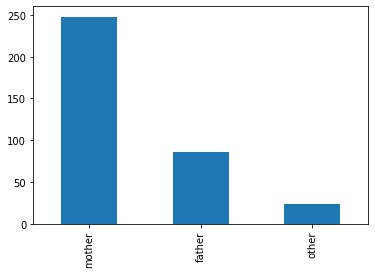



Столбец schoolsup

Всего уникальных значений признака: 3


no     331
yes     49
Name: schoolsup, dtype: int64

Пустых значений: 9


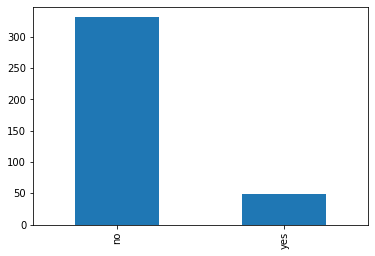



Столбец famsup

Всего уникальных значений признака: 3


yes    216
no     135
Name: famsup, dtype: int64

Пустых значений: 38


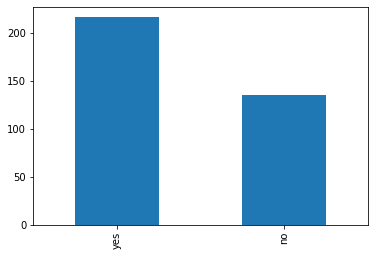



Столбец paid

Всего уникальных значений признака: 3


no     197
yes    153
Name: paid, dtype: int64

Пустых значений: 39


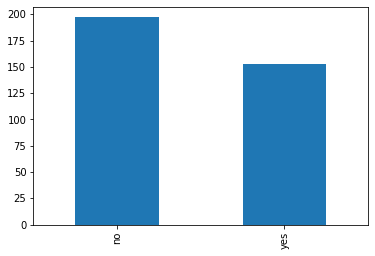



Столбец activities

Всего уникальных значений признака: 3


yes    192
no     183
Name: activities, dtype: int64

Пустых значений: 14


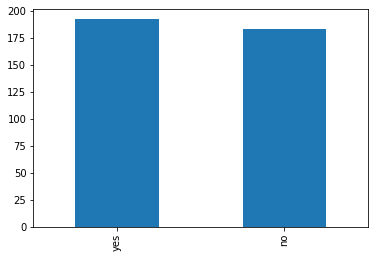



Столбец nursery

Всего уникальных значений признака: 3


yes    297
no      77
Name: nursery, dtype: int64

Пустых значений: 15


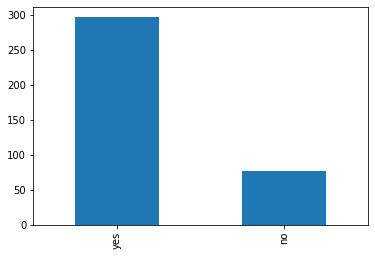



Столбец higher

Всего уникальных значений признака: 3


yes    350
no      19
Name: higher, dtype: int64

Пустых значений: 20


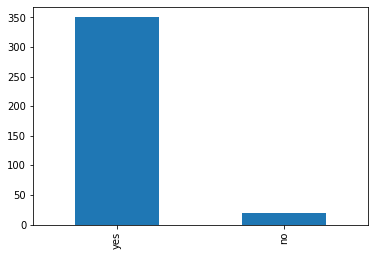



Столбец internet

Всего уникальных значений признака: 3


yes    300
no      55
Name: internet, dtype: int64

Пустых значений: 34


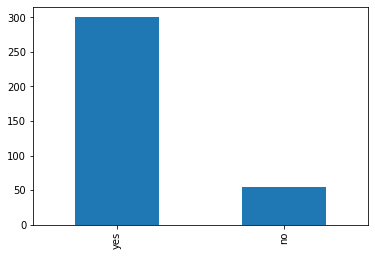



Столбец romantic

Всего уникальных значений признака: 3


no     235
yes    123
Name: romantic, dtype: int64

Пустых значений: 31


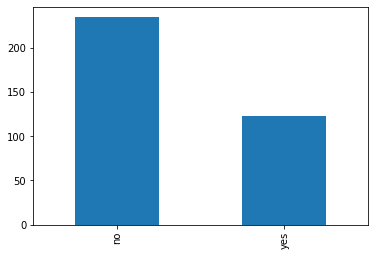

In [11]:
# Создаим краткое описание каждого номинмального столбца
for column in stud_math.columns:
    describe_object_columns(column)

In [12]:
# Функция дает краткое описание каждого порядкового и числового столбца
def describe_numeric_columns(column):
    if stud_math[column].dtype != 'object':
        # Преобразуем пустые ячейки в Null
        stud_math[column].apply(lambda x: None if (x == 'NaN' or x == '') else x)        
        print(f'Столбец {column}')
        print()
        # Количество значений Null
        print(f'Пустых значений: {stud_math.loc[pd.isnull(stud_math[column])][column].size}')
        stud_math[column].hist()
        plt.show()
        display(stud_math[column].describe())

Столбец age

Пустых значений: 0


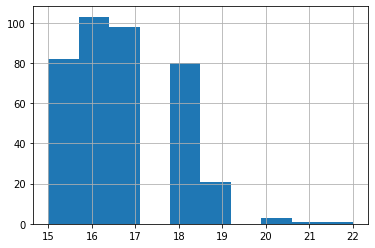

count    389.000000
mean      16.673522
std        1.265662
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

Столбец Medu

Пустых значений: 3


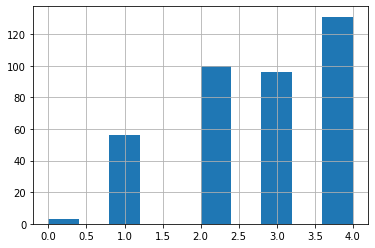

count    386.000000
mean       2.766839
std        1.094277
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: Medu, dtype: float64

Столбец Fedu

Пустых значений: 24


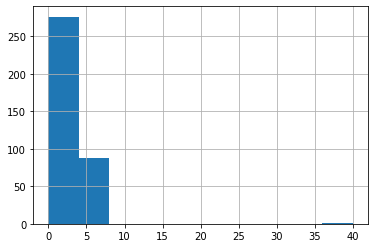

count    365.000000
mean       2.627397
std        2.241790
min        0.000000
25%        2.000000
50%        3.000000
75%        3.000000
max       40.000000
Name: Fedu, dtype: float64

Столбец traveltime

Пустых значений: 28


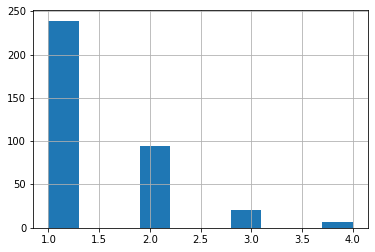

count    361.000000
mean       1.434903
std        0.692660
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: traveltime, dtype: float64

Столбец studytime

Пустых значений: 7


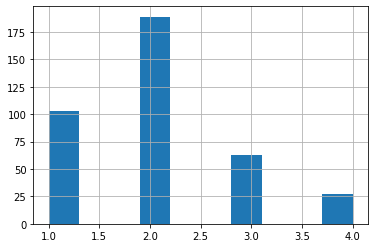

count    382.000000
mean       2.036649
std        0.847239
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: studytime, dtype: float64

Столбец failures

Пустых значений: 22


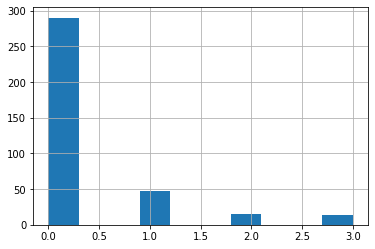

count    367.000000
mean       0.326975
std        0.729479
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64

Столбец famrel

Пустых значений: 27


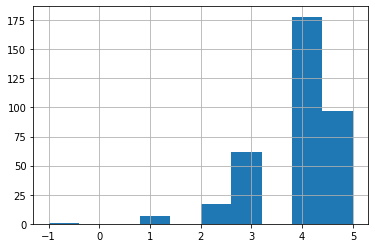

count    362.000000
mean       3.930939
std        0.931554
min       -1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: famrel, dtype: float64

Столбец freetime

Пустых значений: 9


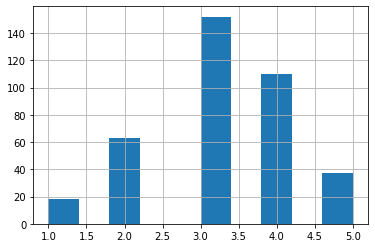

count    380.000000
mean       3.223684
std        0.993364
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: freetime, dtype: float64

Столбец goout

Пустых значений: 7


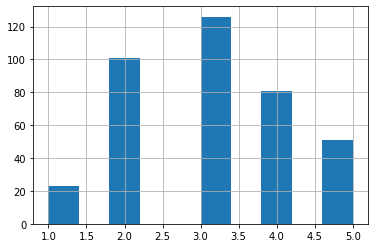

count    382.000000
mean       3.094241
std        1.116104
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: goout, dtype: float64

Столбец health

Пустых значений: 15


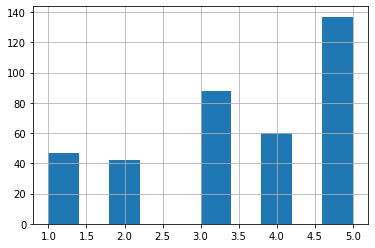

count    374.000000
mean       3.529412
std        1.402006
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64

Столбец absences

Пустых значений: 11


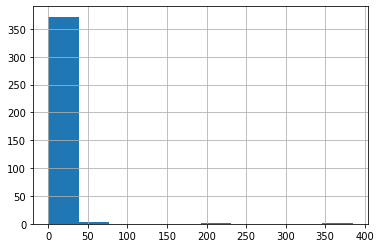

count    378.000000
mean       7.320106
std       23.615525
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

Столбец score

Пустых значений: 0


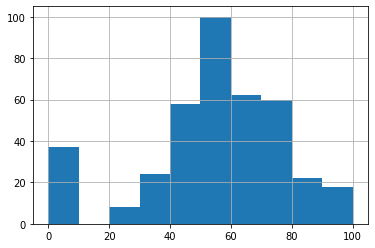

count    389.000000
mean      52.262211
std       22.919022
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

In [13]:
# Создаим краткое описание каждого порядкового и числового столбца
for column in stud_math.columns:
    describe_numeric_columns(column)

In [14]:
# В столбце "Fedu" есть ошибки, так как по условию значание не может превышать 4
stud_math[stud_math['Fedu'] > 4]

,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
11,F,15,U,GT3,NaN,2.0,40.0,services,other,reputation,father,3.0,3.0,0.0,no,yes,no,yes,yes,yes,yes,no,5.0,2.0,2.0,4.0,4.0,60.0


In [15]:
# По всей видимости это опечатка, имелось в виду значение 4. Заменяем 40 на 4.
stud_math.loc[stud_math['Fedu'] > 4, 'Fedu'] = 4

Столбец Fedu

Пустых значений: 24


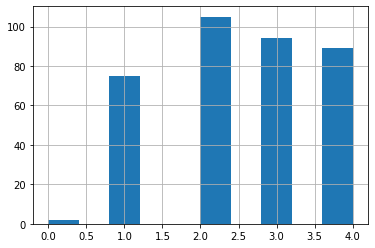

count    365.000000
mean       2.528767
std        1.088082
min        0.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: Fedu, dtype: float64

In [16]:
describe_numeric_columns('Fedu')

In [17]:
# В столбце "famrel" есть ошибки, так как по условию значание не может быть меньше 0
stud_math[stud_math['famrel'] < 0]

,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
25,F,16,U,GT3,NaN,2.0,2.0,services,services,home,mother,1.0,1.0,2.0,no,yes,yes,no,no,yes,yes,no,-1.0,2.0,2.0,5.0,14.0,40.0


In [18]:
# По всей видимости это опечатка, имелось в виду значение 1. Заменяем -1 на 1.
stud_math.loc[stud_math['famrel'] < 0, 'famrel'] = 1

Столбец famrel

Пустых значений: 27


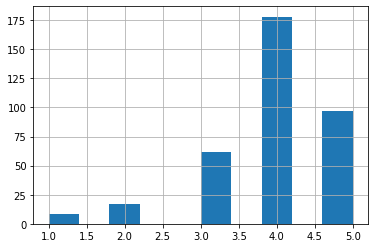

count    362.000000
mean       3.936464
std        0.907858
min        1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: famrel, dtype: float64

In [19]:
describe_numeric_columns('famrel')

In [20]:
# Есть подозрение, что в столбцах "age" и "absences" есть выбросы справа

# Функция рассчитывает правую границу, свыше которой находятся данные выборасов
def outlier(column):
    median = stud_math[column].median()
    IQR = stud_math[column].quantile(0.75) - stud_math[column].quantile(0.25)
    return stud_math[column].quantile(0.75) + 1.5 * IQR

In [21]:
# Заменяем значения выбросов на Null
stud_math.loc[stud_math['age'] > outlier('age'), 'age'] = None
stud_math.loc[stud_math['absences'] > outlier('absences'), 'absences'] = None

Столбец age

Пустых значений: 1


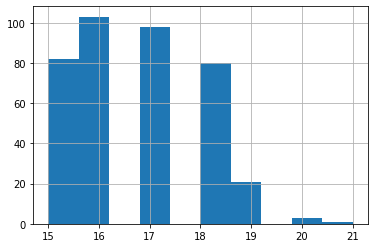

count    388.000000
mean      16.659794
std        1.237958
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       21.000000
Name: age, dtype: float64

In [22]:
describe_numeric_columns('age')

Столбец absences

Пустых значений: 28


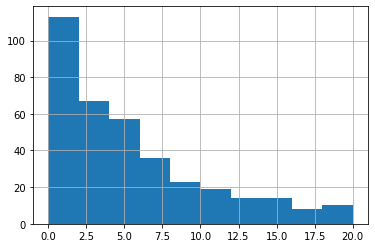

count    361.000000
mean       4.609418
std        4.989413
min        0.000000
25%        0.000000
50%        4.000000
75%        7.000000
max       20.000000
Name: absences, dtype: float64

In [23]:
describe_numeric_columns('absences')

В столбце "score" явным выборосом являются данные со значением 0. Можно предположить, что это ученики, по каким-либо причинам пропустившие экзамен. Так как причины пропуска экзамена неизвестны, балл 0 не дает представления о их реальном знании математики.

In [24]:
# Исключим такие данные их рассматриваемого набора
stud_math.drop(stud_math[stud_math['score']==0].index, axis='index', inplace=True)

# 2. Корреляционный анализ

Применим корреляционный анализ ко всем порядковым и числовым данным.

In [25]:
stud_math.corr()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score
age,1.000000,-0.128496,-0.115096,0.106431,0.004173,0.193357,0.059252,-0.004895,0.105288,-0.034894,0.187220,-0.121579
Medu,-0.128496,1.000000,0.606270,-0.165394,0.070533,-0.205944,-0.006133,0.021002,0.080556,-0.038050,0.034569,0.186477
Fedu,-0.115096,0.606270,1.000000,-0.145471,-0.010779,-0.268901,-0.016694,-0.030449,0.044127,0.018671,-0.040331,0.135268
traveltime,0.106431,-0.165394,-0.145471,1.000000,-0.101490,0.091757,-0.029299,-0.023067,0.029374,-0.000092,-0.044581,-0.075516
studytime,0.004173,0.070533,-0.010779,-0.101490,1.000000,-0.156406,0.057143,-0.128661,-0.029686,-0.085469,-0.094304,0.142055
failures,0.193357,-0.205944,-0.268901,0.091757,-0.156406,1.000000,0.006870,0.127391,0.126770,0.064083,0.172971,-0.289377
famrel,0.059252,-0.006133,-0.016694,-0.029299,0.057143,0.006870,1.000000,0.158597,0.045341,0.107055,-0.112595,0.040590
freetime,-0.004895,0.021002,-0.030449,-0.023067,-0.128661,0.127391,0.158597,1.000000,0.296392,0.072729,0.090665,-0.012457
goout,0.105288,0.080556,0.044127,0.029374,-0.029686,0.126770,0.045341,0.296392,1.000000,-0.010343,0.131236,-0.182286
health,-0.034894,-0.038050,0.018671,-0.000092,-0.085469,0.064083,0.107055,0.072729,-0.010343,1.000000,-0.007110,-0.075340


Достаточно высокий уровень коррекляции между "Medu" и "Fedu", но не на столько, чтобы исключить одну из переменных.

Не обнаружено числовых переменных с высоким уровнем корреляции с "score".

# 3. Анализ номинальных переменных

Проведем анализ номинальных переменнных. Так как порядковые переменые занимают "промежуточные" значения между номимальными и числовыми переменными, включим в этот анализ и порядковые переменные. 

In [26]:
# Функция построение графиков для переменных одного столбца.
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.boxplot(x=column,
                y='score',
                data=stud_math,
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

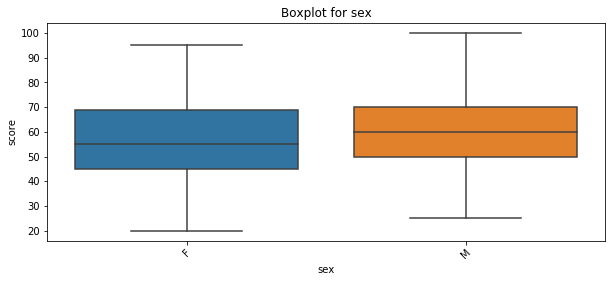

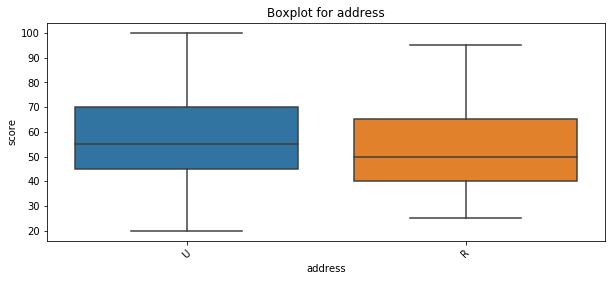

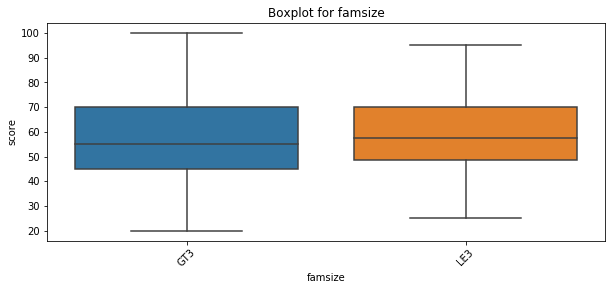

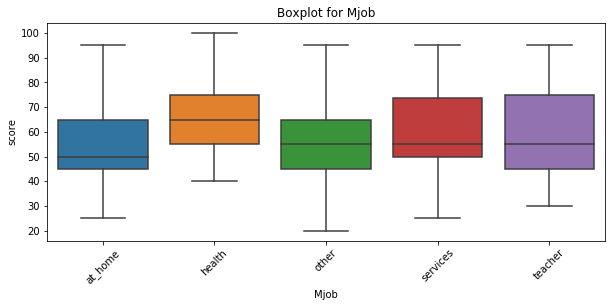

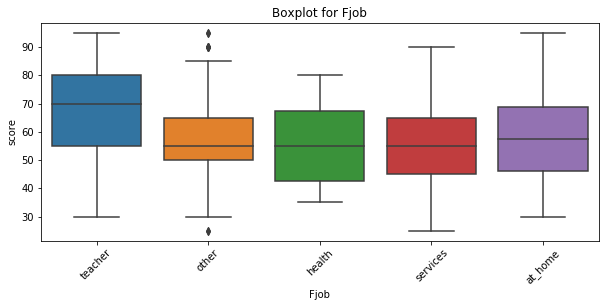

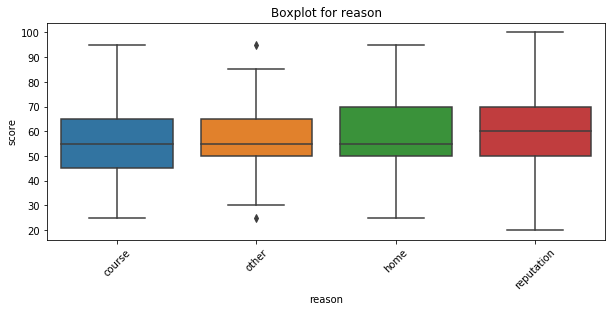

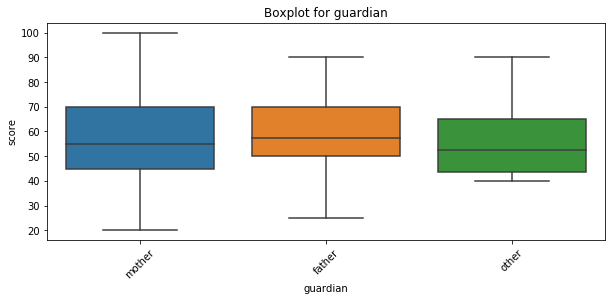

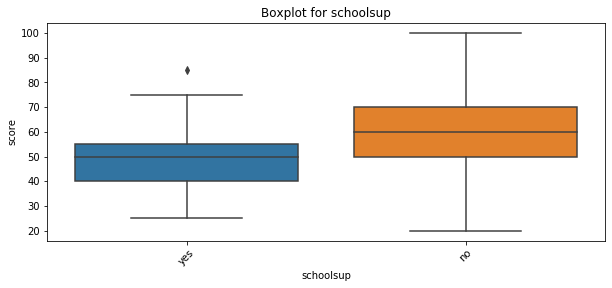

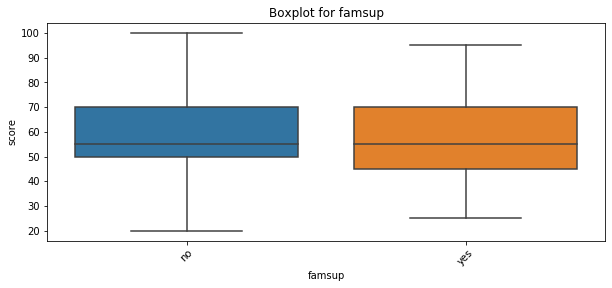

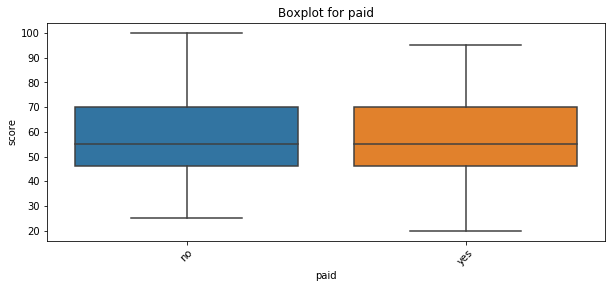

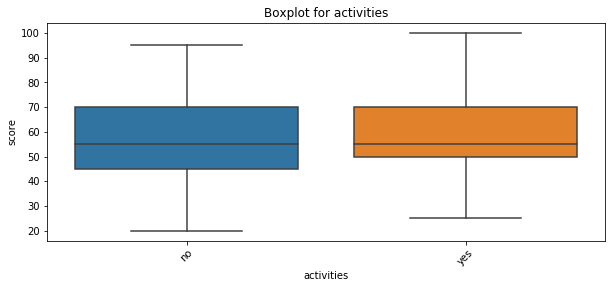

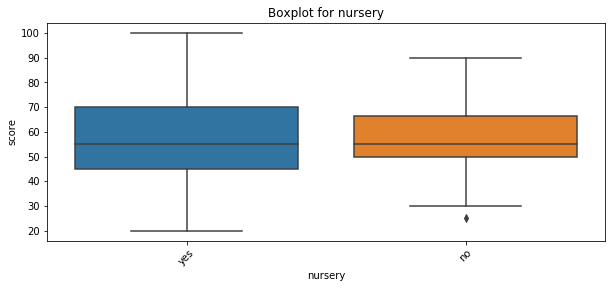

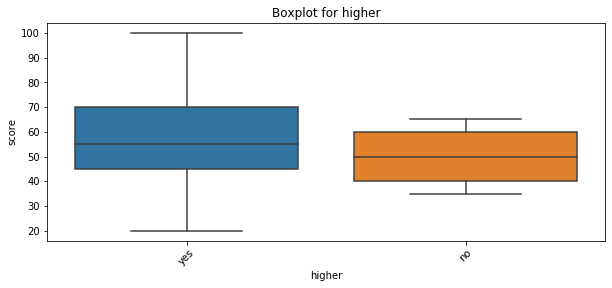

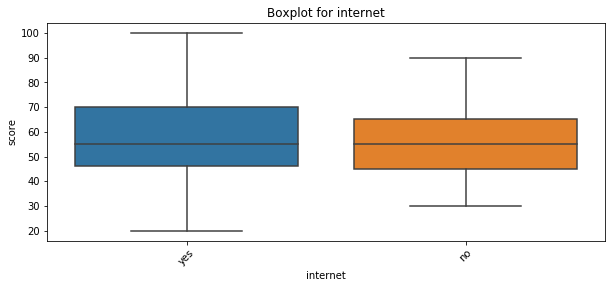

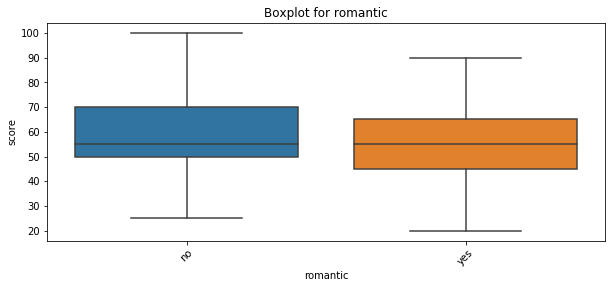

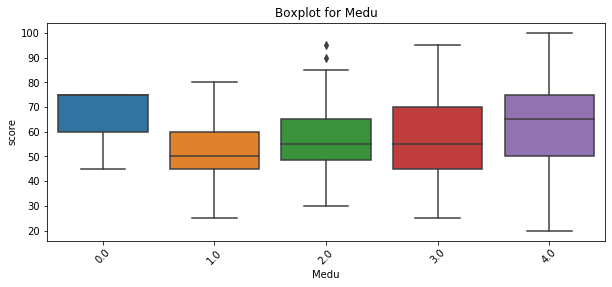

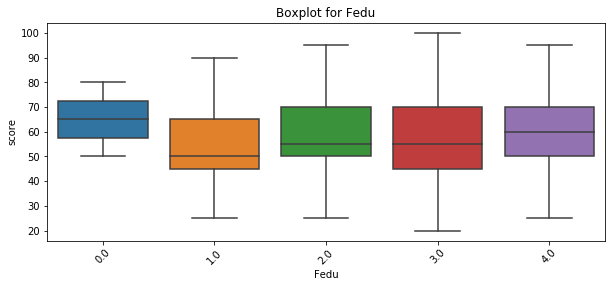

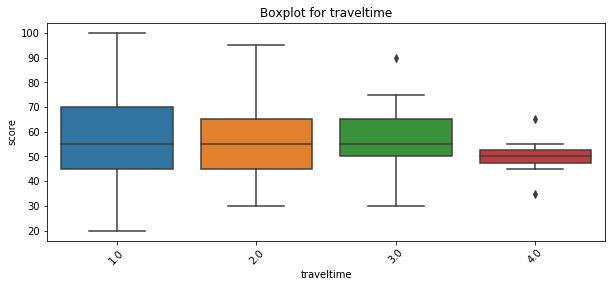

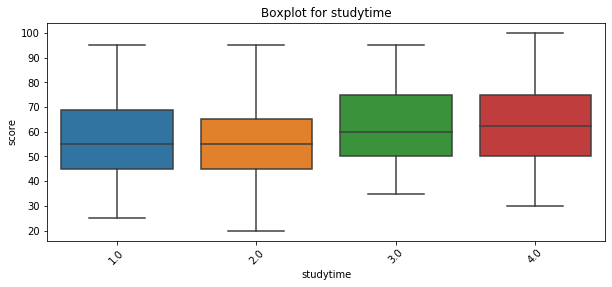

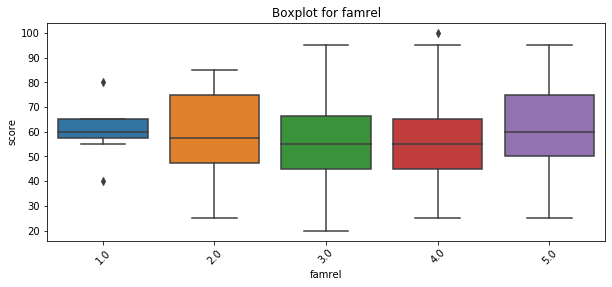

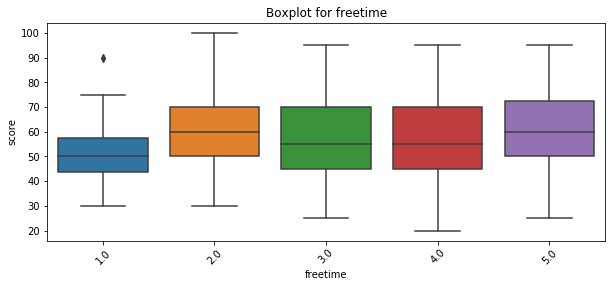

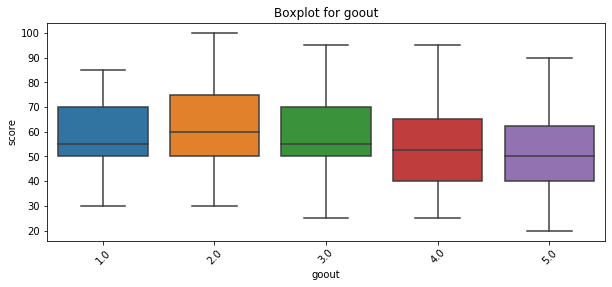

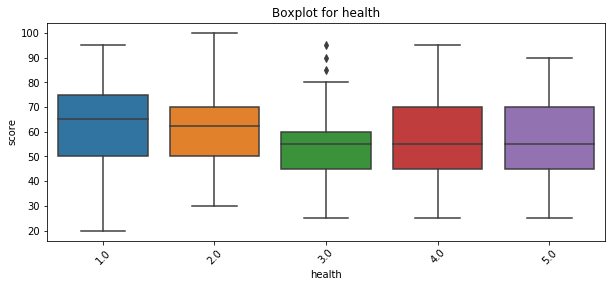

In [27]:
list_to_analyze = ["sex", "address", "famsize", "Mjob", "Fjob", "reason", "guardian", "schoolsup", "famsup",
                   "paid", "activities", "nursery", "higher", "internet", "romantic", "Medu", "Fedu", "traveltime",
                   "studytime", "famrel", "freetime", "goout", "health"]
for col in list_to_analyze:
    get_boxplot(col)

Результататы построения графико не дают показаний к исключению какой-либо переменной из анализа.

Проведем оценку с помощью теста Стьюдента. Для каждого значения переменной проверим, есть ли статистически обоснованные различия. За нулевую гипотизу установим, что распределение оценки по разным значениям параметра не различимы.

In [28]:
# Функция поиска для каждой пары значений параметра не попадания в интервал с достоверностью 95%
def get_stat_dif(column):
    cols = stud_math[column].unique()
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        ttest_result = ttest_ind(stud_math.loc[stud_math.loc[:, column] == comb[0], 'score'],
                                 stud_math.loc[stud_math.loc[:, column] == comb[1], 'score']).pvalue
        if ttest_result <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            print('Пара: ', comb, ', значение: ', ttest_result)

In [29]:
for col in list_to_analyze:
     get_stat_dif(col)

Найдены статистически значимые различия для колонки address
Пара:  ('U', 'R') , значение:  0.010954630500627841
Найдены статистически значимые различия для колонки Mjob
Пара:  ('at_home', 'health') , значение:  0.0027982059798529013
Найдены статистически значимые различия для колонки Mjob
Пара:  ('health', 'other') , значение:  0.0017949217915780725
Найдены статистически значимые различия для колонки Fjob
Пара:  ('teacher', 'other') , значение:  0.002778578861364664
Найдены статистически значимые различия для колонки Fjob
Пара:  ('teacher', 'services') , значение:  0.002516318803149705
Найдены статистически значимые различия для колонки schoolsup
Пара:  ('yes', 'no') , значение:  2.8152819921387307e-06
Найдены статистически значимые различия для колонки Medu
Пара:  (4.0, 1.0) , значение:  0.0003042766207529531
Найдены статистически значимые различия для колонки Fedu
Пара:  (4.0, 1.0) , значение:  0.0032509610703755198
Найдены статистически значимые различия для колонки studytime
Пара: 

Подробнее изучим параметры со статистически значимыми различиями

In [30]:
list_to_analyze = ['address', 'Mjob', 'Fjob', 'schoolsup', 'Medu', 'Fedu', 'studytime', 'goout']

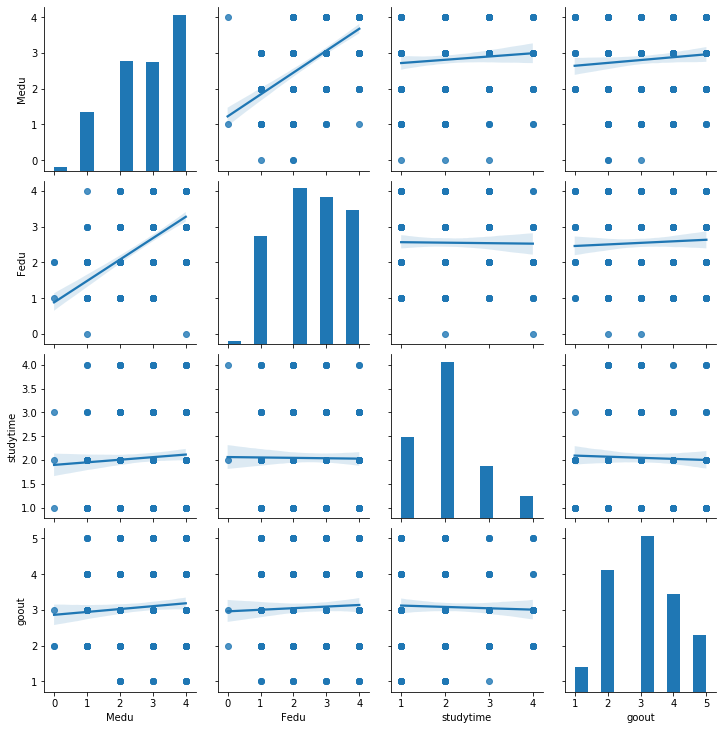

In [31]:
sns.pairplot(stud_math[list_to_analyze], kind='reg')

Корреляция показателей "Medu" и "Fedu" достаточно высокая. Попробуем создать единый интегральный показатель.

In [32]:
# Возьмем максимальный уровень образования родителей в семье
stud_math['edu_max'] = stud_math[['Medu', 'Fedu']].max(axis=1)

In [33]:
# Проверим, как коррелирует новый показатель с двумя исходными
stud_math[['Medu', 'Fedu', 'edu_max']].corr()

,Medu,Fedu,edu_max
Medu,1.000000,0.606270,0.888493
Fedu,0.606270,1.000000,0.786255
edu_max,0.888493,0.786255,1.000000


Уровень корреляции очень высок

In [34]:
# Проверим, сохраняются ли статистически значимые различия для нового показателя
get_stat_dif('edu_max')

Найдены статистически значимые различия для колонки edu_max
Пара:  (4.0, 1.0) , значение:  0.0002458315469719384
Найдены статистически значимые различия для колонки edu_max
Пара:  (4.0, 3.0) , значение:  0.00827395345547404


Статистически значимые различия сохраняются

Другие кандидаты на объединение - "Mjob" и "Fjob".
Однако, параметры пар со значимыми изменениями этих двух показателей различные: в "Mjob" выделяется "health", в "Fjob" - "teacher". Объединить показатель в интегральный не получится.

Можно предположить, что уровень образования связан с местом работы.

In [35]:
# Для проверки этой гипотизы модернизируем функцию построения графиков
def get_boxplot_detail(column, value):
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.boxplot(x=column,
                y=value,
                data=stud_math,
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

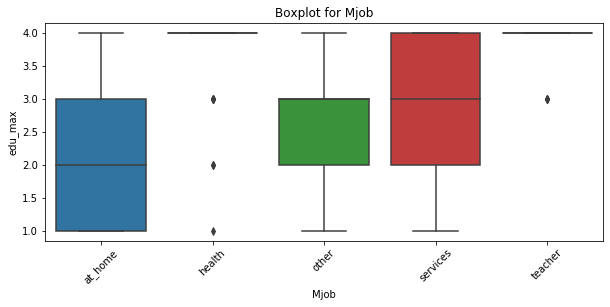

In [36]:
get_boxplot_detail('Mjob','edu_max')

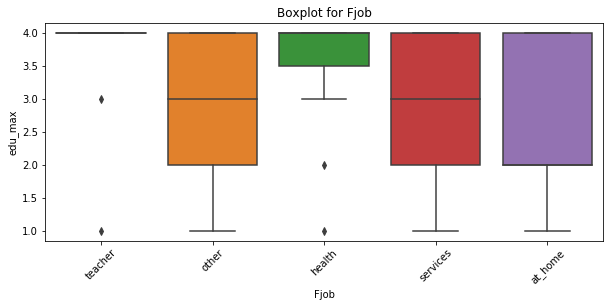

In [37]:
get_boxplot_detail('Fjob','edu_max')

Проведем оценку с помощью теста Стьюдента. Для каждого значения переменной проверим, есть ли статистически обоснованные различия. За нулевую гипотизу установим, что распределение уровня образования по месту работы не различимы.

In [38]:
# Функция поиска для каждой пары параметров не попадания в интервал с достоверностью 95%
def get_stat_dif_detail(column, value):
    cols = stud_math[column].unique()
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        ttest_result = ttest_ind(stud_math.loc[stud_math.loc[:, column] == comb[0], value],
                                 stud_math.loc[stud_math.loc[:, column] == comb[1], value]).pvalue
        if ttest_result <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            print('Пара: ', comb, ', значение: ', ttest_result)

In [39]:
get_stat_dif_detail('Mjob','edu_max')

Найдены статистически значимые различия для колонки Mjob
Пара:  ('at_home', 'health') , значение:  2.0513310926268528e-08
Найдены статистически значимые различия для колонки Mjob
Пара:  ('at_home', 'services') , значение:  2.890270055034613e-06
Найдены статистически значимые различия для колонки Mjob
Пара:  ('at_home', 'teacher') , значение:  2.439598683156309e-19
Найдены статистически значимые различия для колонки Mjob
Пара:  ('health', 'other') , значение:  1.384731313035701e-06
Найдены статистически значимые различия для колонки Mjob
Пара:  ('health', 'services') , значение:  0.00169186584462913
Найдены статистически значимые различия для колонки Mjob
Пара:  ('other', 'services') , значение:  0.002543848362612714
Найдены статистически значимые различия для колонки Mjob
Пара:  ('other', 'teacher') , значение:  1.4304996399976264e-16
Найдены статистически значимые различия для колонки Mjob
Пара:  ('services', 'teacher') , значение:  5.524513381044293e-11


На основании вышесказанного, можно заключить, что есть зависимость между максимальным уровнем образованием родителей и местом работы матери и отца. Следовательно в модели можем использовать один показатель - максимальный уровень образования родителей.

# Вывод

Таким образом, в качестве параметров модели представляется целесообразным использовать следующие показатели:
    - тип адреса ученика ("address");
    - максимальный уровень образования родителей (интегральный "Medu", "Fedu")
    - дополнительная образовательная поддержка ("schoolsup")
    - время на учебу помимо школы ("studytime")
    - проведение времени с друзьями ("goout")